code to predict pv generation

In [ ]:
# env - model-run-tf_env Python 3.10.16

import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

from prophet import Prophet

# Third party packages.
import os                       # Execute tasks related to your operating system.
import polars as pl
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime

import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler



Data Understanding

Load data set. Split with 80% and 20% split

In [11]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
MODEL_RUN_RESULTS_DIR = config["ned"]["ned_model_run_download_dir"]

print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
# pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{DOWNLOAD_DIR}power-gen-consolidated-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)

# Sum of all columns starting with 'production'
# df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
df_pd_orig["Total_Production"] = df_pd_orig["volume_0"]
df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,validto,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_3,production_biogas,capacity_4,...,production_electricitymix,capacity_28,production_electricitymix.1,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_industrialconsumersgascombination,Total_Production
0,2022-01-01 00:00:00+00:00,8098513,8098513,2031015,2031015,0,0,568004,568004,161795,...,10246506,NaN,NaN,1127491,1127491,482,482,1865500,1865500,8098513
1,2022-01-01 01:00:00+00:00,7914843,7914843,1864849,1864849,0,0,568014,568014,198870,...,10083044,NaN,NaN,1184195,1184195,391,391,1839500,1839500,7914843
2,2022-01-01 02:00:00+00:00,7442013,7442013,1784513,1784513,0,0,568023,568023,222172,...,9595627,NaN,NaN,1181864,1181864,444,444,1429250,1429250,7442013


Descriptive Statistics

In [12]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 51 numerical variables:
Index(['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2',
       'production_solar', 'capacity_3', 'production_biogas', 'capacity_4',
       'production_heatpump', 'capacity_8', 'production_cofiring',
       'capacity_9', 'production_geothermal', 'capacity_10',
       'production_other', 'capacity_11', 'production_waste', 'capacity_12',
       'production_biooil', 'capacity_13', 'production_biomass', 'capacity_14',
       'production_wood', 'capacity_17', 'production_windoffshore',
       'capacity_18', 'production_fossilgaspower', 'capacity_19',
       'production_fossilhardcoal', 'capacity_20', 'production_nuclear',
       'capacity_21', 'production_wastepower', 'capacity_22',
       'production_windoffshoreB', 'capacity_25', 'production_biomasspower',
       'capacity_26', 'production_otherpower', 'capacity_27',
       'production_electricitymix', 'capacity_28',
       'production_electricitymix.1', 'capacity_35', 'production_CHP

To check if the output column has unique values

In [13]:
l_col = ['Total_Production']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Total_Production']:        Total_Production
0               8098513
1               7914843
2               7442013
3               7470598
4               7425668
...                 ...
26299          15441356
26300          15390012
26301          15298923
26302          15150733
26303          15169196

[26304 rows x 1 columns]
Total_Production: [ 8098513  7914843  7442013 ... 15298923 15150733 15169196]


Contruct a descriptive summary

In [14]:
df_pd_orig.describe()

,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_3,production_biogas,capacity_4,production_heatpump,...,production_electricitymix,capacity_28,production_electricitymix.1,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_industrialconsumersgascombination,Total_Production
count,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,26304.000000,26304.000000,2.630400e+04,2.630400e+04,...,2.630400e+04,6.377000e+03,6.377000e+03,2.630400e+04,2.630400e+04,26304.000000,26304.000000,2.630400e+04,2.630400e+04,2.630400e+04
mean,1.002881e+07,1.002881e+07,1.867822e+06,1.867822e+06,2.467901e+06,2.467901e+06,470389.771594,470389.771594,6.375008e+05,6.375008e+05,...,1.352914e+07,1.131498e+07,1.131498e+07,1.663086e+06,1.663086e+06,42418.259960,42418.259960,1.308883e+06,1.308883e+06,1.002881e+07
std,4.730942e+06,4.730942e+06,1.724212e+06,1.724212e+06,3.850288e+06,3.850288e+06,102494.001389,102494.001389,4.450993e+05,4.450993e+05,...,4.009711e+06,1.358170e+06,1.358170e+06,6.544200e+05,6.544200e+05,65692.270586,65692.270586,1.068610e+06,1.068610e+06,4.730942e+06
min,2.495282e+06,2.495282e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,367002.000000,367002.000000,3.925200e+04,3.925200e+04,...,3.476983e+06,3.885110e+06,3.885110e+06,4.414480e+05,4.414480e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,2.495282e+06
25%,6.201201e+06,6.201201e+06,3.823895e+05,3.823895e+05,0.000000e+00,0.000000e+00,385642.500000,385642.500000,2.965032e+05,2.965032e+05,...,1.049245e+07,1.096225e+07,1.096225e+07,1.177204e+06,1.177204e+06,355.000000,355.000000,3.720008e+05,3.720008e+05,6.201201e+06
50%,9.336639e+06,9.336639e+06,1.311126e+06,1.311126e+06,8.141500e+04,8.141500e+04,417301.000000,417301.000000,5.699665e+05,5.699665e+05,...,1.326964e+07,1.139893e+07,1.139893e+07,1.566794e+06,1.566794e+06,1933.000000,1933.000000,1.060625e+06,1.060625e+06,9.336639e+06
75%,1.302629e+07,1.302629e+07,3.046544e+06,3.046544e+06,3.826383e+06,3.826383e+06,589188.500000,589188.500000,8.631202e+05,8.631202e+05,...,1.640090e+07,1.220615e+07,1.220615e+07,2.025625e+06,2.025625e+06,63783.750000,63783.750000,2.090000e+06,2.090000e+06,1.302629e+07
max,2.918097e+07,2.918097e+07,6.518273e+06,6.518273e+06,1.973623e+07,1.973623e+07,652995.000000,652995.000000,3.208576e+06,3.208576e+06,...,2.967770e+07,1.488739e+07,1.488739e+07,3.940000e+06,3.940000e+06,296529.000000,296529.000000,4.342999e+06,4.342999e+06,2.918097e+07


Function to capture metrics from prediction models

In [15]:
# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# List to store results
results = []

Prepare data for prediction

In [16]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

df['year'] = df['validto'].dt.year
df['month'] = df['validto'].dt.month
df['day'] = df['validto'].dt.day
df['day_of_week'] = df['validto'].dt.dayofweek
df['week_of_year'] = df['validto'].dt.isocalendar().week

df['lag_1'] = df['Total_Production'].shift(1)
df['lag_2'] = df['Total_Production'].shift(2)
df['rolling_mean_3'] = df['Total_Production'].shift(1).rolling(window=3).mean()

features = ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'rolling_mean_3']
X = df[features]
y = df['Total_Production']

tscv = TimeSeriesSplit(n_splits=5)

# Example to get the latest train-test split
for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index].copy()
    test = df.iloc[test_index].copy()


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 4693590.627575566
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1719907200]  ┆ 9965954  ┆ 11044779  ┆ -1078825 │
│ [1719910800]  ┆ 11401283 ┆ 11044876  ┆ 356407   │
│ [1719914400]  ┆ 13011227 ┆ 11044974  ┆ 1966253  │
│ [1719918000]  ┆ 14483817 ┆ 11045071  ┆ 3438746  │
│ [1719921600]  ┆ 15102601 ┆ 11045169  ┆ 4057432  │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 15441356 ┆ 11471580  ┆ 3969776  │
│ [1735675200]  ┆ 15390012 ┆ 11471678  ┆ 3918334  │
│ [1735678800]  ┆ 15298923 ┆ 11471775  ┆ 3827148  │
│ [1735682400]  ┆ 15150733 ┆ 11471873  ┆ 3678860  │
│ [1735686000]  ┆ 15169196 ┆ 11471970  ┆ 3697226  │
└───────────────┴──────────┴───────────┴──────────┘


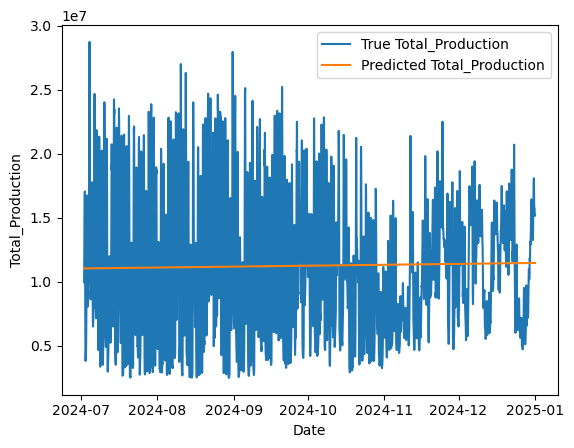

In [17]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Total_Production']  # 'Total_Production' as the target

model_run_start_time = time.time()

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['Total_Production']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

aic_lr = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Linear Regression", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])




Naive Model

In [18]:
# Step 7: Naive Forecast - last value of training set as prediction
model_run_start_time = time.time()
y_naive_pred = np.full_like(y_test, y_train.iloc[-1])
model_run_end_time = time.time()

aic_naive = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae_naive = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae_naive}")

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Store results
results.append(["Naive Model", 
                mean_absolute_error(y_test, y_naive_pred),
                np.sqrt(mean_squared_error(y_test, y_naive_pred)), 
                mean_absolute_percentage_error(y_test, y_naive_pred), 
                symmetric_mape(y_test, y_naive_pred), 
                aic_naive,
                execution_time])


Mean Absolute Error (MAE): 4693590.627575566


Prophet Model Run

20:36:09 - cmdstanpy - INFO - Chain [1] start processing
20:36:16 - cmdstanpy - INFO - Chain [1] done processing


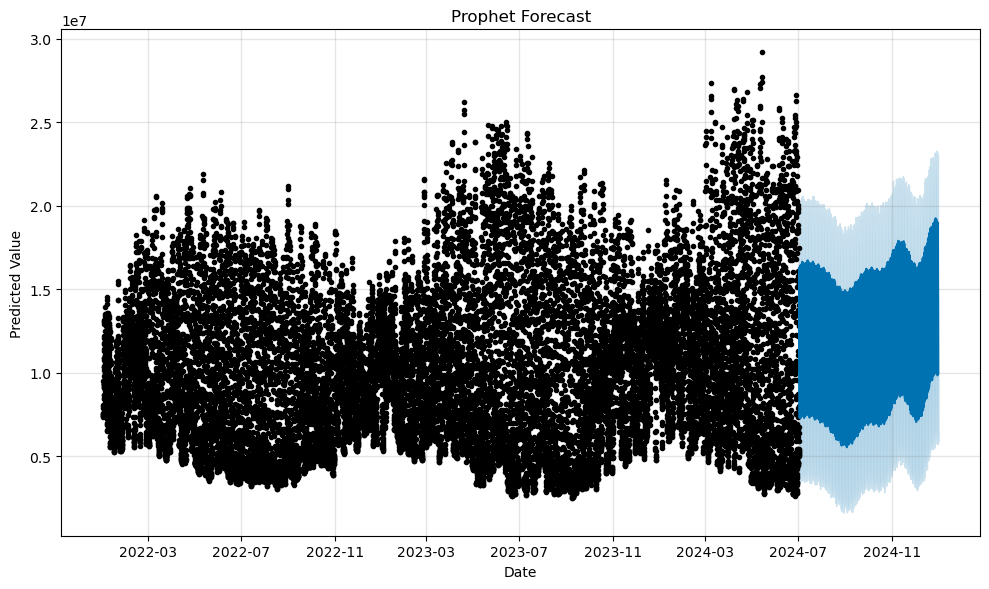

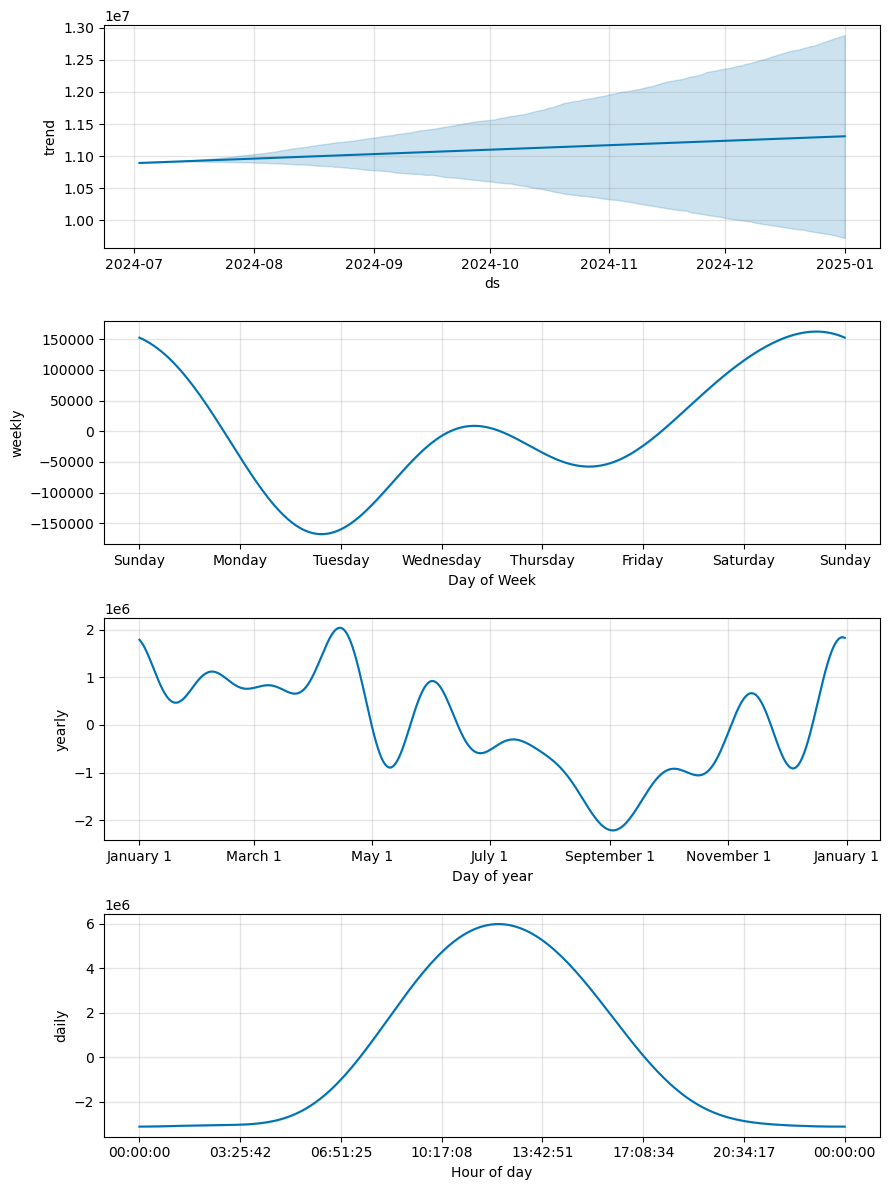

Mean Absolute Error (MAE): 4693590.627575566
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1719907200]  ┆ 9965954  ┆ 11044779  ┆ -1078825 │
│ [1719910800]  ┆ 11401283 ┆ 11044876  ┆ 356407   │
│ [1719914400]  ┆ 13011227 ┆ 11044974  ┆ 1966253  │
│ [1719918000]  ┆ 14483817 ┆ 11045071  ┆ 3438746  │
│ [1719921600]  ┆ 15102601 ┆ 11045169  ┆ 4057432  │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 15441356 ┆ 11471580  ┆ 3969776  │
│ [1735675200]  ┆ 15390012 ┆ 11471678  ┆ 3918334  │
│ [1735678800]  ┆ 15298923 ┆ 11471775  ┆ 3827148  │
│ [1735682400]  ┆ 15150733 ┆ 11471873  ┆ 3678860  │
│ [1735686000]  ┆ 15169196 ┆ 11471970  ┆ 3697226  │
└───────────────┴──────────┴───────────┴──────────┘


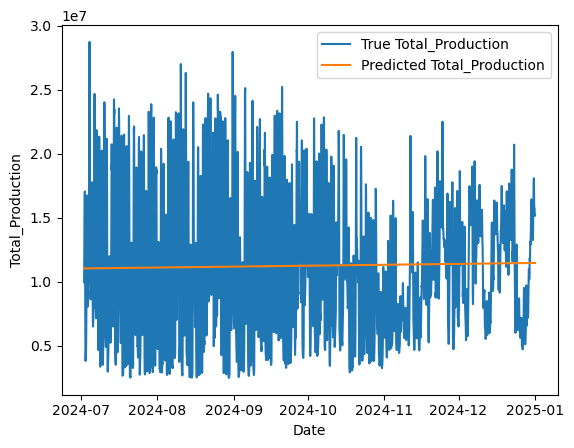

In [19]:
# Step 1: Prepare training data for Prophet
train_prophet = train[['validto', 'Total_Production']].rename(columns={'validto': 'ds', 'Total_Production': 'y'})
test_prophet = test[['validto', 'Total_Production']].rename(columns={'validto': 'ds', 'Total_Production': 'y'})

# Remove timezone if present
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)
test_prophet['ds'] = test_prophet['ds'].dt.tz_localize(None)

# Step 2: Train Prophet model
model = Prophet()
model.fit(train_prophet)

# Step 3: Create future dataframe for the test period
future = test_prophet[['ds']].copy()

# Step 4: Forecast
forecast = model.predict(future)

# Step 5: Evaluation
y_true = test_prophet['y'].values
y_pred = forecast['yhat'].values

y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Step 6: Plot the forecast
model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Value")
plt.tight_layout()
plt.show()

# Optional: Plot forecast components (trend, weekly, yearly seasonality)
model.plot_components(forecast)
plt.tight_layout()
plt.show()


mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

aic_prophet = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Prophet", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_prophet,
                execution_time])


ARIMA Model

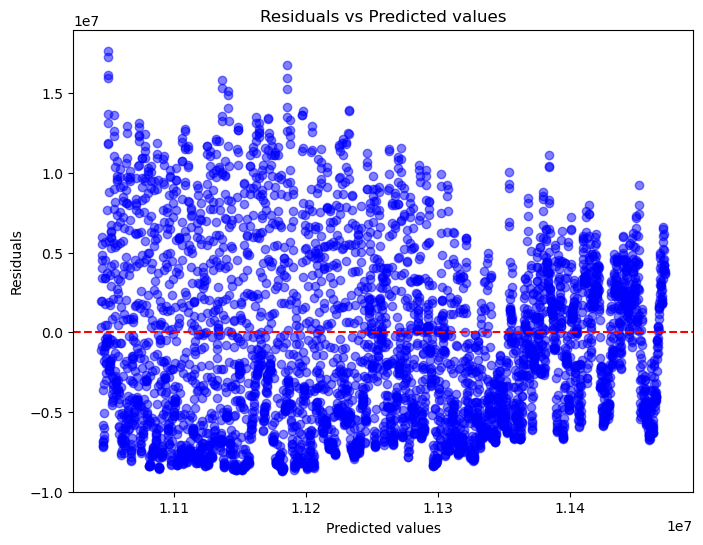

In [20]:
# 2️⃣ ARIMA Model (Example Order: (1,1,1))
model_run_start_time = time.time()
arima_model = ARIMA(y_train, order=(1,1,1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
model_run_end_time = time.time()

aic_arima = arima_model.aic  # Directly from ARIMA model

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["ARIMA (1,1,1)", 
                mean_absolute_error(y_test, y_pred_arima),
                np.sqrt(mean_squared_error(y_test, y_pred_arima)), 
                mean_absolute_percentage_error(y_test, y_pred_arima), 
                symmetric_mape(y_test, y_pred_arima), 
                aic_arima,
                execution_time])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

SARIMA Model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48353D+01    |proj g|=  6.50534D-02

At iterate    5    f=  1.48262D+01    |proj g|=  6.36285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   2.843D-06   1.483D+01
  F =   14.826219761905593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


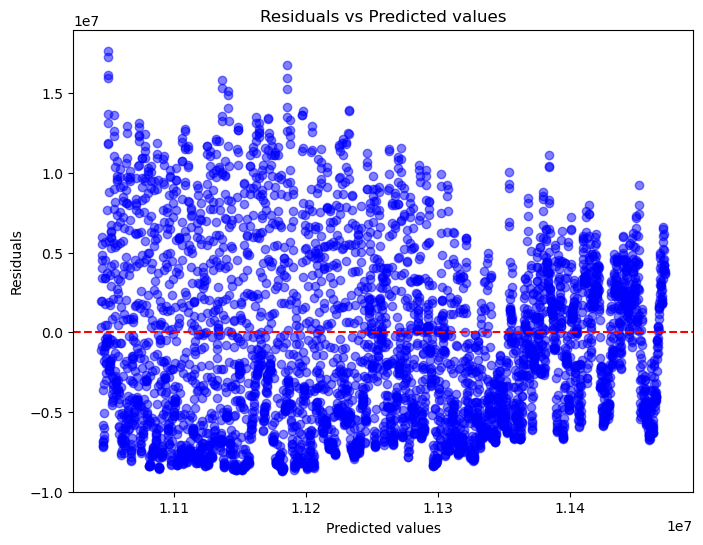

In [21]:
model_run_start_time = time.time()
sarima_model = SARIMAX(y_train, order=(1, 1, 3), seasonal_order=(0, 0, 0, 7)).fit()
# Forecast the next steps (same length as y_test)
y_pred_sarima = sarima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# Get the AIC value from the SARIMA model
aic_sarima = sarima_model.aic  # Directly from SARIMA model
model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["SARIMAX (1,1,3)", 
                mean_absolute_error(y_test, y_pred_sarima),
                np.sqrt(mean_squared_error(y_test, y_pred_sarima)), 
                mean_absolute_percentage_error(y_test, y_pred_sarima), 
                symmetric_mape(y_test, y_pred_sarima), 
                aic_sarima,
                execution_time])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

Predict using LASSO model

In [22]:

# Train Lasso Regression Model
model_run_start_time = time.time()
lasso = Lasso(alpha=0.2)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["LASSO", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])


Mean Absolute Error: 4693590.627575552
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1719907200]  ┆ 9965954  ┆ 11044779  ┆ -1078825 │
│ [1719910800]  ┆ 11401283 ┆ 11044876  ┆ 356407   │
│ [1719914400]  ┆ 13011227 ┆ 11044974  ┆ 1966253  │
│ [1719918000]  ┆ 14483817 ┆ 11045071  ┆ 3438746  │
│ [1719921600]  ┆ 15102601 ┆ 11045169  ┆ 4057432  │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 15441356 ┆ 11471580  ┆ 3969776  │
│ [1735675200]  ┆ 15390012 ┆ 11471678  ┆ 3918334  │
│ [1735678800]  ┆ 15298923 ┆ 11471775  ┆ 3827148  │
│ [1735682400]  ┆ 15150733 ┆ 11471873  ┆ 3678860  │
│ [1735686000]  ┆ 15169196 ┆ 11471970  ┆ 3697226  │
└───────────────┴──────────┴───────────┴──────────┘


Predict using decision tree regression

In [23]:

# Train Decision Tree Regressor Model
model_run_start_time = time.time()
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["Decision Tree", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])



Mean Absolute Error: 4578736.861216111
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬─────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff    │
│ ---           ┆ ---      ┆ ---       ┆ ---     │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64     │
╞═══════════════╪══════════╪═══════════╪═════════╡
│ [1719907200]  ┆ 9965954  ┆ 10574641  ┆ -608687 │
│ [1719910800]  ┆ 11401283 ┆ 10574641  ┆ 826642  │
│ [1719914400]  ┆ 13011227 ┆ 10574641  ┆ 2436586 │
│ [1719918000]  ┆ 14483817 ┆ 10574641  ┆ 3909176 │
│ [1719921600]  ┆ 15102601 ┆ 10574641  ┆ 4527960 │
│ …             ┆ …        ┆ …         ┆ …       │
│ [1735671600]  ┆ 15441356 ┆ 10574641  ┆ 4866715 │
│ [1735675200]  ┆ 15390012 ┆ 10574641  ┆ 4815371 │
│ [1735678800]  ┆ 15298923 ┆ 10574641  ┆ 4724282 │
│ [1735682400]  ┆ 15150733 ┆ 10574641  ┆ 4576092 │
│ [1735686000]  ┆ 15169196 ┆ 10574641  ┆ 4594555 │
└───────────────┴──────────┴───────────┴─────────┘


Predit using Random Forest regressor

In [24]:
# Train Random Forest Regressor Model
model_run_start_time = time.time()

# Make Predictions
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["Random Forest", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])

Mean Absolute Error: 4499613.441026156
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬─────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff    │
│ ---           ┆ ---      ┆ ---       ┆ ---     │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64     │
╞═══════════════╪══════════╪═══════════╪═════════╡
│ [1719907200]  ┆ 9965954  ┆ 9780056   ┆ 185898  │
│ [1719910800]  ┆ 11401283 ┆ 9780056   ┆ 1621227 │
│ [1719914400]  ┆ 13011227 ┆ 9780056   ┆ 3231171 │
│ [1719918000]  ┆ 14483817 ┆ 9780056   ┆ 4703761 │
│ [1719921600]  ┆ 15102601 ┆ 9780056   ┆ 5322545 │
│ …             ┆ …        ┆ …         ┆ …       │
│ [1735671600]  ┆ 15441356 ┆ 9780056   ┆ 5661300 │
│ [1735675200]  ┆ 15390012 ┆ 9780056   ┆ 5609956 │
│ [1735678800]  ┆ 15298923 ┆ 9780056   ┆ 5518867 │
│ [1735682400]  ┆ 15150733 ┆ 9780056   ┆ 5370677 │
│ [1735686000]  ┆ 15169196 ┆ 9780056   ┆ 5389140 │
└───────────────┴──────────┴───────────┴─────────┘


XGBoost Model


Average MAE: 489129.47940237226
Average RMSE: 708568.9102658343

Average MAPE: 5.015028646049165
Average SMAPE: 5.002740763460925

Average AIC: 118068.84847659248


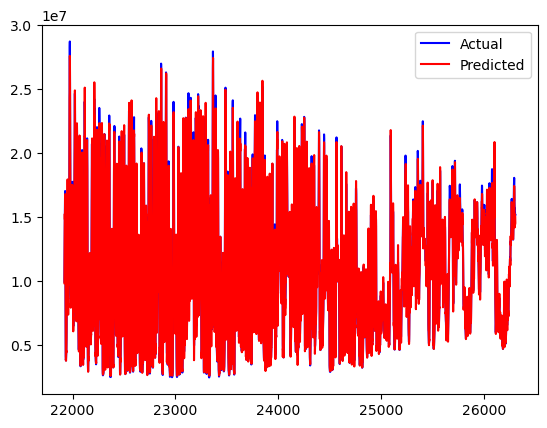

In [25]:
# Create lag features
# df['lag1'] = df['Total_Production'].shift(1)
# df['lag2'] = df['Total_Production'].shift(2)
# df.dropna(inplace=True)

# Example DataFrame `df` with features and target
# df['validto'] should be a datetime column (or already numeric)
X = df[['lag_1', 'lag_2', 'rolling_mean_3', 'month', 'day_of_week']]  # Features
y = df['Total_Production']  # Target variable


# Number of splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Variables to store the performance metrics
mae_scores = []
rmse_scores = []
mape_xgb_scores = []
smape_xgb_scores = []
aic_xgb_scores = []

model_run_start_time = time.time()

# TimeSeriesSplit loop
for train_index, test_index in tscv.split(X):
    # Split data into train and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics for each fold
    mae_xgb = mean_absolute_error(y_test, y_pred)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
    smape_xgb = symmetric_mape(y_test, y_pred)
    aic_xgb = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)
    
    # Append results to the list
    mae_scores.append(mae_xgb)
    rmse_scores.append(rmse_xgb)
    mape_xgb_scores.append(mape_xgb)
    smape_xgb_scores.append(smape_xgb)
    aic_xgb_scores.append(aic_xgb)

# After the loop, print the average performance metrics across all folds
print("\nAverage MAE:", np.mean(mae_scores))
print("Average RMSE:", np.mean(rmse_scores))
print("\nAverage MAPE:", np.mean(mape_xgb_scores))
print("Average SMAPE:", np.mean(smape_xgb_scores))
print("\nAverage AIC:", np.mean(aic_xgb_scores))

model_run_end_time = time.time()

# Plot Results
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Compute evaluation metrics
mae_xgb = np.mean(mae_scores)
rmse_xgb = np.mean(rmse_scores)


# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Append results to results
results.append(["XGBoost", mae_xgb, rmse_xgb, mape_xgb, smape_xgb, aic_xgb, execution_time])


LTSM (Long Short-Term Memory)

Epoch 1/20


/opt/miniconda3/envs/model-run-tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0152
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 8.0053e-04
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 6.1616e-04
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.4834e-04
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.3553e-04
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.2439e-04
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 5.1055e-04
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.0849e-04
Epoch 9/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.8969e-04
Epoch 10/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.7645e-04
Epoch 11/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.6283e-04
Epoch 12/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.7658e-04
Epoch 13/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 4.6165e-04
Epoch 14/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9

/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_20975/3068405381.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


10466368.434887562 11817304.96712146 inf 199.9999847471244 171308.424592684


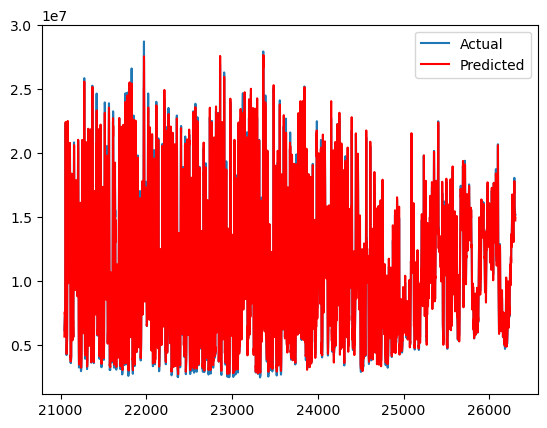

In [26]:
# Load dataset
df = df_pd_orig

# Normalize data
scaler = MinMaxScaler()
df['Total_Production'] = scaler.fit_transform(df[['Total_Production']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Lookback period
data = df['Total_Production'].values
X, y = create_sequences(data, seq_length)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile & Train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict & Inverse Transform
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

# Compute evaluation metrics
mae_ltsm = mean_absolute_error(y_test, y_pred)
rmse_ltsm = np.sqrt(mean_squared_error(y_test, y_pred))
mape_ltsm = mean_absolute_percentage_error(y_test, y_pred)
smape_ltsm = symmetric_mape(y_test, y_pred)
aic_ltsm = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

print(mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm)

# Append results to results
results.append(["LSTM", mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm])

# Plot Results
import matplotlib.pyplot as plt
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

Print Model evaluation results

In [27]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE", "sMAPE", "AIC", "Execution Time"])

metrics_df['Comments'] = 'Addition of Prophet model'

# Display Table
print(metrics_df)

# Define the filename
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_results_file_path = f'{MODEL_RUN_RESULTS_DIR}ned-model-results_{model_run_timestamp}.csv'

# Step 10: Check if file exists, then append or create
if os.path.exists(model_results_file_path):
    # Append to existing file
    existing_results = pd.read_csv(model_results_file_path)
    updated_results = pd.concat([existing_results, metrics_df], ignore_index=True)
    updated_results.to_csv(model_results_file_path, index=False)
else:
    # Create new file
    metrics_df.to_csv(model_results_file_path, index=False)

print(f"✅ Model evaluation saved to {model_results_file_path}")

               Model           MAE          RMSE       MAPE       sMAPE  \
0  Linear Regression  4.693591e+06  5.513835e+06  70.124334   47.179160   
1        Naive Model  4.581184e+06  5.879863e+06  49.747321   46.959689   
2            Prophet  4.693591e+06  5.513835e+06  70.124334   47.179160   
3      ARIMA (1,1,1)  5.512123e+06  6.393478e+06  92.500570   52.265343   
4    SARIMAX (1,1,3)  5.023410e+06  5.838692e+06  80.642767   49.310896   
5              LASSO  4.693591e+06  5.513835e+06  70.124334   47.179160   
6      Decision Tree  4.578737e+06  5.435265e+06  65.045044   46.401344   
7      Random Forest  4.499613e+06  5.451759e+06  59.417694   45.880681   
8            XGBoost  4.891295e+05  7.085689e+05   5.130028    5.133476   
9               LSTM  1.046637e+07  1.181730e+07        inf  199.999985   

             AIC  Execution Time                   Comments  
0  136107.655892        0.009040  Addition of Prophet model  
1  136107.655892        0.000189  Addition of Prop